In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import metrics
import xgboost as xgb

from imblearn.ensemble import BalancedBaggingClassifier

import graphviz
import plotly.graph_objects as go
import plotly.offline as py

from plot_learning_curve import plot_learning_curve

import warnings

In [2]:
from utils_two import *

In [33]:
def model_train(x_train, x_test, y_train, y_test, model_func, parameters_grid=None):

    if parameters_grid:
        model = model_func()

        gridSearch = GridSearchCV(model,parameters_grid,cv = 10, scoring=roc_auc_weighted)
        gridSearch.fit(x_train,y_train)
    #     print(gridSearch.best_score_)
        best_params = gridSearch.best_params_
        print(best_params)

        model = model_func()
        model.set_params(**gridSearch.best_params_)
    else:
        model = model_func()

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    try:
        y_pred_prob = model.predict_proba(x_test)[:,1]
    except:
        y_pred_prob = y_pred
    print('In-Sample Accuracy: ', round(model.score(x_train, y_train) * 100, 2), '%')
    print('Out-of-Sample Accuracy: ', round(model.score(x_test, y_test) * 100, 2), '%', '\n')
    model_describe(y_test,y_pred,y_pred_prob)
    
    return model

In [32]:
def my_evaluation(model_func, parameters_grid, parameters_grid_two=None):
    global c_X_test
    global nc_X_test
    global c_Y_test
    global nc_Y_test
    global c_X_train
    global nc_X_train
    global c_Y_train
    global nc_Y_train
    global roc_auc_weighted
    
    if parameters_grid_two == None:
        parameters_grid_two = parameters_grid
    nc_model = model_train(nc_X_train, nc_X_test, nc_Y_train, nc_Y_test, model_func, parameters_grid)
    c_model = model_train(c_X_train, c_X_test, c_Y_train, c_Y_test, model_func, parameters_grid_two)
    
    comb_result(nc_model, c_model)
    
    return nc_model, c_model

In [9]:
smote = SMOTE()
ncr = NeighbourhoodCleaningRule()

sns.set()

warnings.filterwarnings('ignore')

In [10]:
roc_auc_weighted = metrics.make_scorer(metrics.roc_auc_score, average='micro')

In [11]:
model_list = [LogisticRegression,SVC,RandomForestClassifier,KNeighborsClassifier,GaussianNB,Perceptron,SGDClassifier,DecisionTreeClassifier]

###  Load Data

In [12]:
cluster_path = '../data_stage2/kmeans.csv'

# new feature after svd reducing dimention
feature_path = '../data_stage2/new_svd.csv'

# new feature
# feature_path = '../data_stage2/new_feature.csv'

In [13]:
cluster_df = pd.read_csv(cluster_path ,index_col = 0).drop(['status'], axis=1)
data_df =  pd.read_csv(feature_path, index_col = 0)

In [14]:
new_columns = list(map(lambda x:"V"+str(x), data_df.columns[:-1])) + [data_df.columns[-1]]
data_df.columns = new_columns

In [15]:
cluster_df.cluster.value_counts()

1    12293
0     2437
Name: cluster, dtype: int64

Normalization

In [16]:
initial_status = data_df.status
data_df = (data_df - data_df.mean())/data_df.std()
data_df['status'] = initial_status

In [17]:
connect_data = data_df.loc[cluster_df.cluster == 0]
nonconnect_data = data_df.loc[cluster_df.cluster == 1]
connect_data.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,status
X1,,,,,,,,,,,,,,,,
2,1.279717,-3.328058,-5.020785,-0.389619,-2.239806,-0.169296,-0.156509,0.354404,-0.638349,0.978494,-2.017139,1.208772,-3.474224,-0.116181,-1.527483,1
3,3.624793,-0.485160,-4.325553,2.560247,-5.382775,-1.096725,3.044048,1.667689,1.642113,0.175686,6.643368,1.289934,-0.411690,11.143016,0.445406,1
10,1.765376,-0.654096,-1.361595,-0.340505,-0.401943,-0.405088,-0.124910,-0.238743,-0.133406,-0.229374,-0.273569,0.097707,-0.599625,-1.903279,1.269703,1
12,2.048123,-0.198814,-0.258832,-0.255830,0.541413,0.099160,0.042303,-0.327871,0.499683,-0.250045,0.037233,0.300208,-0.536633,-1.599506,0.299389,1
16,1.919571,0.063845,0.141789,-0.535175,0.190851,-0.578577,-0.475715,-0.453883,-0.565284,0.155454,0.676097,-0.537623,-0.791226,-0.886279,-0.341464,1


In [18]:
print('connect_data.shape', connect_data.shape)
print('nonconnect_data.shape', nonconnect_data.shape)
print('connect_data.status.value_counts()\n', connect_data.status.value_counts())
print('nonconnect_data.status.value_counts()\n', nonconnect_data.status.value_counts())

connect_data.shape (2437, 16)
nonconnect_data.shape (12293, 16)
connect_data.status.value_counts()
 0    1558
1     879
Name: status, dtype: int64
nonconnect_data.status.value_counts()
 0    11591
1      702
Name: status, dtype: int64


Split

In [20]:
c_X_train,c_X_test,c_Y_train,c_Y_test = train_test_split(connect_data.drop(['status'], axis=1),connect_data.status,test_size = 0.3,random_state = 0) 

nc_X_train,nc_X_test,nc_Y_train,nc_Y_test = train_test_split(nonconnect_data.drop(['status'], axis=1),nonconnect_data.status,test_size = 0.3,random_state = 0)

c_X_train,c_X_test,c_Y_train,c_Y_test = my_preprocess(c_X_train,c_X_test,c_Y_train,c_Y_test)
nc_X_train,nc_X_test,nc_Y_train,nc_Y_test = my_preprocess(nc_X_train,nc_X_test,nc_Y_train,nc_Y_test)

In [36]:
print(c_Y_test.shape)

print(nc_Y_test.shape)

(732,)
(3688,)


Resample

In [21]:
nc_Y_train.value_counts()

0    10095
1      610
Name: status, dtype: int64

In [22]:
nc_X_train, nc_Y_train = ncr.fit_sample(nc_X_train, nc_Y_train)

In [24]:
nc_Y_train.value_counts()

0    8615
1     610
Name: status, dtype: int64

## Single Model

### Logistic Regression

In [25]:
logsitcregressionCV_parameters_grid = {
    'class_weight':['balanced'],
    'penalty':['l1','l2','elasticnet'],
    'solver':['liblinear','saga','lbfgs'],
    'Cs':np.arange(0.5,2,0.2),
    'max_iter' : [500],
    'scoring': [roc_auc_weighted]
}

{'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'scoring': make_scorer(roc_auc_score, average=micro), 'solver': 'liblinear'}
In-Sample Accuracy:  68.36 %
Out-of-Sample Accuracy:  66.75 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      3477
           1       0.11      0.67      0.19       211

    accuracy                           0.67      3688
   macro avg       0.54      0.67      0.49      3688
weighted avg       0.92      0.67      0.76      3688


AUC score 0.7269749620730406


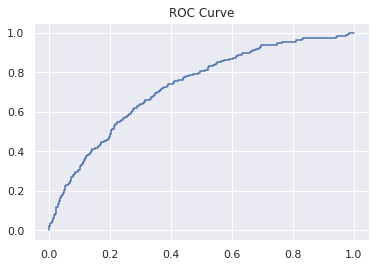

{'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'scoring': make_scorer(roc_auc_score, average=micro), 'solver': 'liblinear'}
In-Sample Accuracy:  75.0 %
Out-of-Sample Accuracy:  72.4 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       473
           1       0.62      0.67      0.65       259

    accuracy                           0.74       732
   macro avg       0.72      0.72      0.72       732
weighted avg       0.75      0.74      0.74       732


AUC score 0.7899058829291387


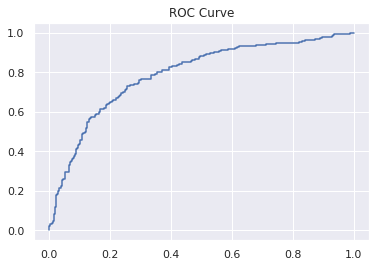

Model Summary Report
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      3950
           1       0.20      0.67      0.31       470

    accuracy                           0.68      4420
   macro avg       0.57      0.67      0.55      4420
weighted avg       0.87      0.68      0.74      4420


AUC score 0.7337193643953677


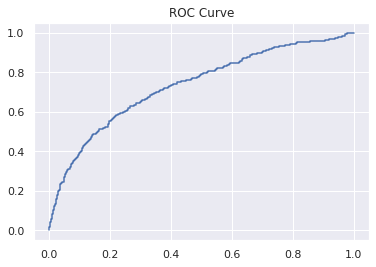

In [649]:
nc_lr_model, c_lr_model = my_evaluation(LogisticRegressionCV, logsitcregressionCV_parameters_grid)

### SVC Regression

In [650]:
svc_regression_parameters_grid={
    'C':np.arange(0.5,2,0.2),
    'kernel':['linear','poly','rbf','sigmoid'],
    'gamma':['scale','auto'],
    'kernel':['rbf'],
    'gamma':['auto'],
    'class_weight':['balanced']
}

{'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
In-Sample Accuracy:  76.48 %
Out-of-Sample Accuracy:  70.36 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      3477
           1       0.13      0.75      0.23       211

    accuracy                           0.70      3688
   macro avg       0.56      0.73      0.52      3688
weighted avg       0.93      0.70      0.78      3688


AUC score 0.7270792356542042


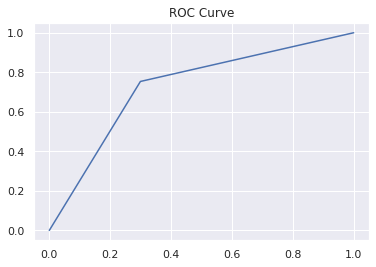

{'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
In-Sample Accuracy:  81.73 %
Out-of-Sample Accuracy:  77.19 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       473
           1       0.66      0.75      0.70       259

    accuracy                           0.77       732
   macro avg       0.75      0.77      0.76       732
weighted avg       0.78      0.77      0.77       732


AUC score 0.7666949643693829


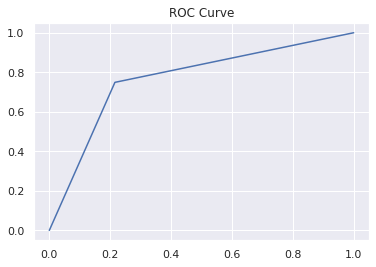

Model Summary Report
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      3950
           1       0.24      0.75      0.36       470

    accuracy                           0.71      4420
   macro avg       0.60      0.73      0.59      4420
weighted avg       0.88      0.71      0.77      4420


AUC score 0.7308483705898196


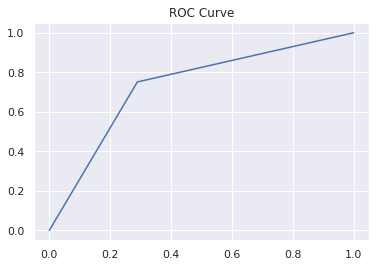

In [651]:
nc_svc_model, c_svc_model= my_evaluation(SVC, svc_regression_parameters_grid)

### Decision Tree

In [652]:
decision_parameters_grid = {
    'max_depth':np.arange(3,20,2),
#     'max_depth':[15],
    'class_weight':['balanced'],
    'max_features':['auto','sqrt','log2']
}

{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt'}
In-Sample Accuracy:  76.02 %
Out-of-Sample Accuracy:  72.13 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      3477
           1       0.12      0.59      0.19       211

    accuracy                           0.72      3688
   macro avg       0.54      0.66      0.51      3688
weighted avg       0.92      0.72      0.80      3688


AUC score 0.6961604150224836


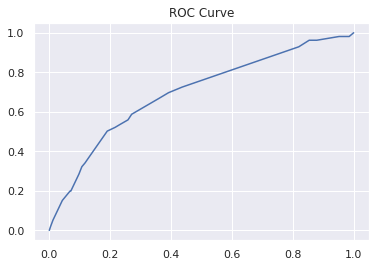

{'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'auto'}
In-Sample Accuracy:  83.61 %
Out-of-Sample Accuracy:  77.05 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       473
           1       0.67      0.69      0.68       259

    accuracy                           0.77       732
   macro avg       0.75      0.75      0.75       732
weighted avg       0.77      0.77      0.77       732


AUC score 0.7994930901907646


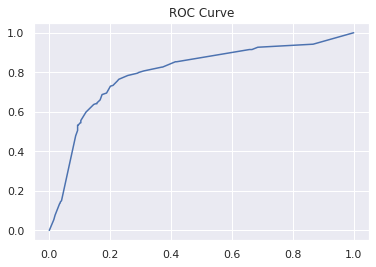

Model Summary Report
              precision    recall  f1-score   support

           0       0.95      0.74      0.83      3950
           1       0.23      0.65      0.34       470

    accuracy                           0.73      4420
   macro avg       0.59      0.69      0.58      4420
weighted avg       0.87      0.73      0.78      4420


AUC score 0.7377726905467276


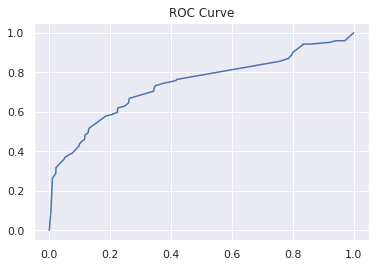

In [653]:
nc_dt_model, c_dt_model = my_evaluation(DecisionTreeClassifier, decision_parameters_grid)

## Combine The Single Model

In [654]:
nc_model = VotingClassifier(estimators=[('lr', nc_lr_model), ('svc', nc_svc_model), ('dt', nc_dt_model)], weights=[1,2,1], voting='hard')
nc_model.fit(nc_X_train, nc_Y_train)

nc_y_pred = nc_model.predict(nc_X_test)
nc_y_pred_prob = get_pred_prob(nc_model, nc_X_test)

In [655]:
c_model = VotingClassifier(estimators=[('lr', c_lr_model), ('svc', c_svc_model), ('dt', c_dt_model)],weights=[1,2,1], voting='hard')
c_model.fit(c_X_train, c_Y_train)

c_y_pred = c_model.predict(c_X_test)
c_y_pred_prob = get_pred_prob(c_model, c_X_test)

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      3477
           1       0.14      0.65      0.23       211

    accuracy                           0.75      3688
   macro avg       0.56      0.71      0.54      3688
weighted avg       0.93      0.75      0.82      3688


AUC score 0.7067956387745059


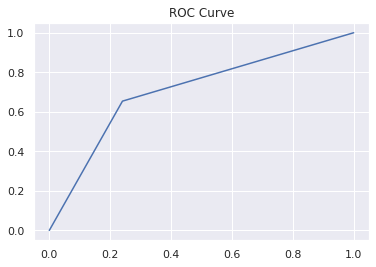

In [656]:
model_describe(nc_Y_test,nc_y_pred,nc_y_pred_prob)

Model Summary Report
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       473
           1       0.68      0.70      0.69       259

    accuracy                           0.78       732
   macro avg       0.76      0.76      0.76       732
weighted avg       0.78      0.78      0.78       732


AUC score 0.760625923416621


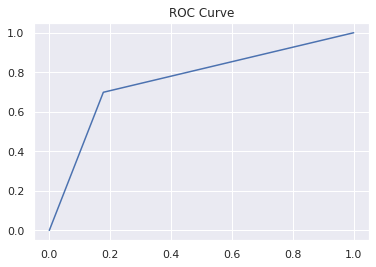

In [657]:
model_describe(c_Y_test,c_y_pred,c_y_pred_prob)

In [658]:
Y_test = list(c_Y_test) + list(nc_Y_test)
y_pred = list(c_y_pred) + list(nc_y_pred)
y_pred_prob = list(c_y_pred_prob) + list(nc_y_pred_prob)

Model Summary Report
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      3950
           1       0.26      0.68      0.37       470

    accuracy                           0.76      4420
   macro avg       0.60      0.72      0.61      4420
weighted avg       0.88      0.76      0.80      4420


AUC score 0.7229060059251279


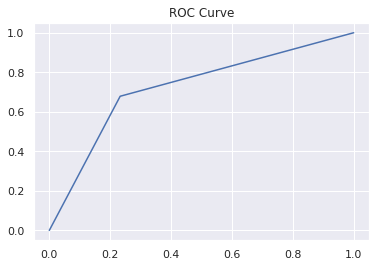

In [659]:
model_describe(Y_test,y_pred,y_pred_prob)

## Ensembl Learning

### Adaboost

In [660]:
adaboost_tree_parameters_grid={
    'base_estimator': [
        DecisionTreeClassifier(max_depth=6, min_samples_split=20, min_samples_leaf=5, class_weight='balanced')
    ],
    'algorithm' : ["SAMME"],
    'n_estimators' : [30,50,100,200,350,500,600],
    'learning_rate' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}

{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.1, 'n_estimators': 300}
In-Sample Accuracy:  78.8 %
Out-of-Sample Accuracy:  72.91 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      3477
           1       0.14      0.73      0.24       211

    accuracy                           0.73      3688
   macro avg       0.56      0.73      0.54      3688
weighted avg       0.93      0.73      0.80      3688


AUC score 0.8073562626167626


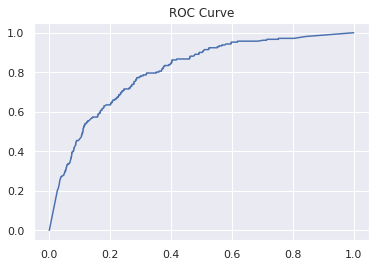

{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.1, 'n_estimators': 300}
In-Sample Accuracy:  90.75 %
Out-of-Sample Accuracy:  82.24 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       473
           1       0.73      0.78      0.76       259

    accuracy                           0.82       732
   macro avg       0.80      0.81      0.81       732
weighted avg       0.83      0.82      0.82       732


AUC score 0.8788314137151347


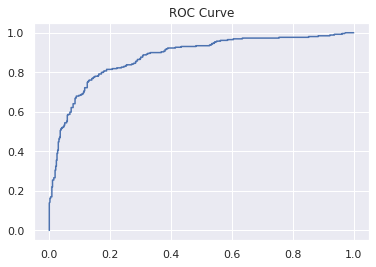

Model Summary Report
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      3950
           1       0.26      0.76      0.39       470

    accuracy                           0.74      4420
   macro avg       0.61      0.75      0.61      4420
weighted avg       0.89      0.74      0.79      4420


AUC score 0.8167301373552384


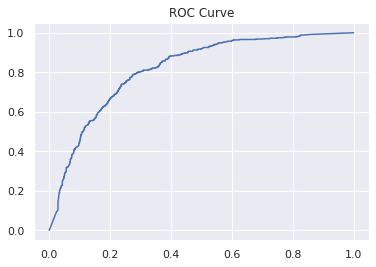

In [661]:
nc_ada_tree_model, c_ada_tree_model = my_evaluation(AdaBoostClassifier, adaboost_tree_parameters_grid)

### Random Forest

In [662]:
randomforest_parameters_grid = {
                'n_estimators':[300,400,500,600,700],
                'max_features': ['auto', 'sqrt'],
                'max_depth ':[1,5,10,15,20,30,40,50],
                'min_samples_split' : [2, 5, 10],
                'min_samples_leaf' : [1, 2, 4],
                'bootstrap' : [True, False]
}

{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
In-Sample Accuracy:  87.87 %
Out-of-Sample Accuracy:  82.51 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      3477
           1       0.18      0.60      0.28       211

    accuracy                           0.83      3688
   macro avg       0.58      0.72      0.59      3688
weighted avg       0.93      0.83      0.87      3688


AUC score 0.8237708325666159


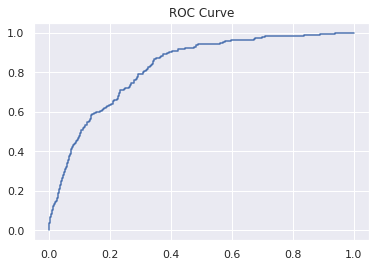

{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
In-Sample Accuracy:  87.86 %
Out-of-Sample Accuracy:  80.46 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       473
           1       0.74      0.70      0.72       259

    accuracy                           0.80       732
   macro avg       0.79      0.78      0.78       732
weighted avg       0.80      0.80      0.80       732


AUC score 0.8641220501685618


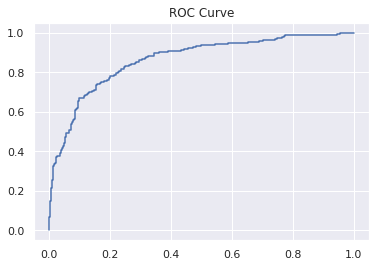

Model Summary Report
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      3950
           1       0.33      0.65      0.44       470

    accuracy                           0.82      4420
   macro avg       0.64      0.75      0.67      4420
weighted avg       0.89      0.82      0.85      4420


AUC score 0.8375065984379207


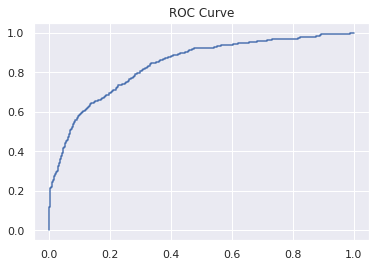

In [663]:
nc_rf_model, c_rf_model = my_evaluation(RandomForestClassifier, randomforest_parameters_grid)

### XGBoost

In [664]:
xgb_regression_parameters_grid={
    'eta': [0.01,0.05,0.1,0.15,0.2,0.25],    #learning rate
    'n_estimators': [600],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'max_depth': [3, 4, 5, 6,7,8,9,10],
    
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'colsample_bytree': [1], 
    'colsample_bylevel': [1], 
    'subsample': [1],
    'reg_lambda': [1],
    'reg_alpha': [0],
    'eval_metric':['error','auc'],
    'objective':['binary:logistic']}

{'colsample_bylevel': 1, 'colsample_bytree': 1, 'eta': 0.05, 'eval_metric': 'error', 'gamma': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 600, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
In-Sample Accuracy:  98.55 %
Out-of-Sample Accuracy:  96.34 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3477
           1       0.79      0.49      0.60       211

    accuracy                           0.96      3688
   macro avg       0.88      0.74      0.79      3688
weighted avg       0.96      0.96      0.96      3688


AUC score 0.9049392964191225


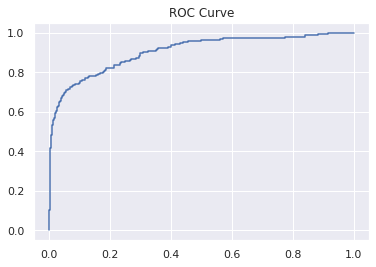

{'colsample_bylevel': 1, 'colsample_bytree': 1, 'eta': 0.05, 'eval_metric': 'error', 'gamma': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 600, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
In-Sample Accuracy:  99.95 %
Out-of-Sample Accuracy:  86.48 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       473
           1       0.85      0.75      0.80       259

    accuracy                           0.86       732
   macro avg       0.86      0.84      0.85       732
weighted avg       0.86      0.86      0.86       732


AUC score 0.912935587354192


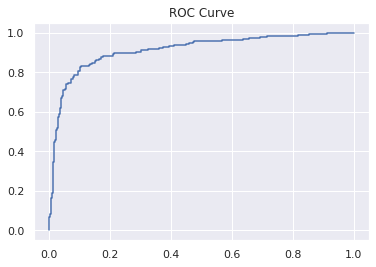

Model Summary Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3950
           1       0.83      0.63      0.72       470

    accuracy                           0.95      4420
   macro avg       0.89      0.81      0.84      4420
weighted avg       0.94      0.95      0.94      4420


AUC score 0.9275496902774039


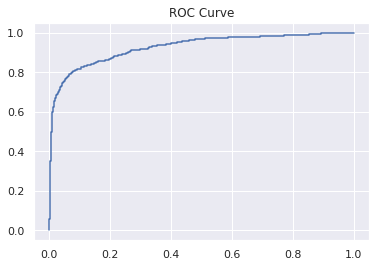

In [665]:
nc_xgb_model, c_xgb_model = my_evaluation(xgb.XGBClassifier, xgb_regression_parameters_grid)

### Tree Structure

In [666]:
dot_data = tree.export_graphviz(nc_rf_model.estimators_[3], out_file=None, 
                                feature_names = connect_data.drop(['status'], axis=1).columns, class_names = True,
                                filled = True, rounded = True) 
graph = graphviz.Source(dot_data) 
graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('random forest.pdf')

True

In [667]:
import pydotplus

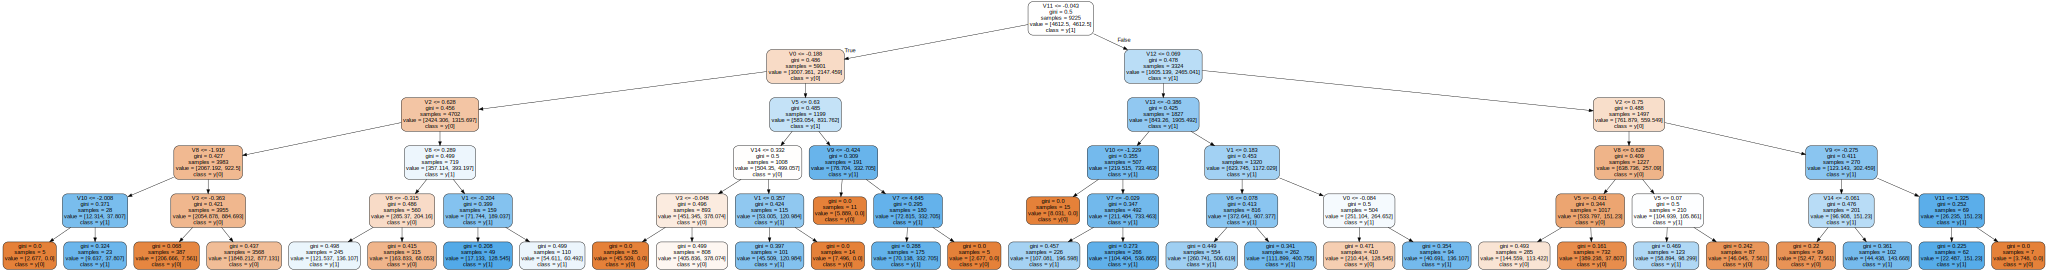

In [668]:
#for nonconnect model: nc_dt_model

dot_data = tree.export_graphviz(nc_dt_model, out_file=None, 
                                feature_names = connect_data.drop(['status'], axis=1).columns, class_names = True,
                                filled = True, rounded = True) 
graph = graphviz.Source(dot_data) 
graph

# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('decision_tree.pdf')

###  Feature importance plotting

####  only random forest and Adaboost tree have feature importance
#### random forest model: nc_rd_model
#### adaboost tree model: nc_ada_tree_model

In [670]:
ada_feature_importance = nc_ada_tree_model.feature_importances_

rf_feature_importance = nc_rf_model.feature_importances_

dt_feature_importance = nc_dt_model.feature_importances_

xgb_feature_importance = nc_xgb_model.feature_importances_

ensemble_mean_feature_importance = (ada_feature_importance + rf_feature_importance + xgb_feature_importance) / 3

In [671]:
dt_model_importance = feature_importance_scatter_plot('Decision Tree',dt_feature_importance,nc_X_train)

In [672]:
ada_model_importance = feature_importance_scatter_plot('AdaBoostClassifier',ada_feature_importance,nc_X_train)

In [673]:
rf_model_importance = feature_importance_scatter_plot('RandomForest',rf_feature_importance,nc_X_train)

In [674]:
xgb_model_importance = feature_importance_scatter_plot('XGBoost',xgb_feature_importance,nc_X_train)

In [675]:
ensemble_mean_model_importance = feature_importance_scatter_plot('Ensemble Mean',ensemble_mean_feature_importance,nc_X_train)